First of all, i've decided to use memory tokens as additional memory approach.

- Together with embeddings of returns, observations/states and actions i use additionally learnable memory embeddings, that are used in transformer attention with other tokens, which has been supposed to enrich r, o/s, a embeddings with missing information in POMDP. To achieve it i've implemented unrolling the sequence of embeddings one-by-one, to update memory embeddings (and with a proper mask - memory embeddings see every other embedding and every embedding see memory), so i suppose it's became a decoder transformer (if compare with gru and lstm, they update memory in an auto-regreesive manner as is without an addtitional code)
- Memory tokens/embeddings are not detached after every forward interation during the unrolling process to enable gradients to flow and update memory through time
- Additionally, i can say that "empty" memory embeddings are trained, so initially at the start of each episode it containes information about the environment (i think it can give the model the information about what the task we trying to solve depending on the environment as well as the entire transformer does). Comparing to gru and lstm memories that init memory (hidden states) by zero at the start - i've managed this after implementing and training, so have decided not to change anything, but i've also tried to initialize memory embeddings (in token memory type) by zeros - the same results
- For a "fair" comparison i use only 1 memory token, but there is no limits - we can add more, and i use only 1 layer of last/gru (and we can add more as well)
- It alsoshould be noted that memory architectures have different number of learnable parameters (for my experiments it is something like gru~25k, lstm~33k, token=64). So memory type = token has only 64 parameters instead of thousands as lstm and gru...

In [6]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [7]:
data = {}
for filename in glob("models/*.csv"):
    _, _, _, _, memory_type, n_layer, _ = filename.split("_")

    if n_layer not in data:
        data[n_layer] = {}

    if memory_type not in data[n_layer]:
        data[n_layer][memory_type] = df = pd.read_csv(filename)

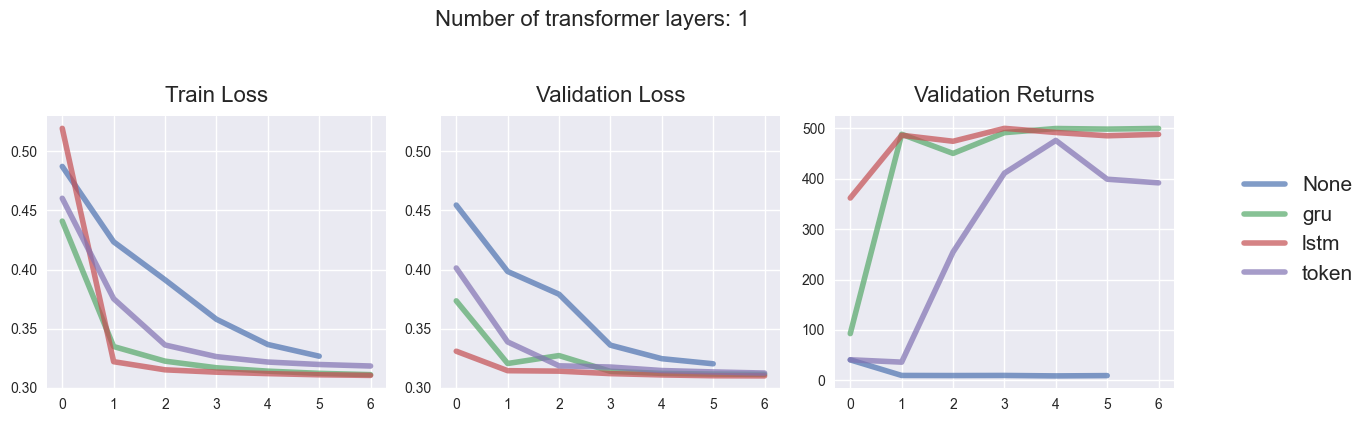

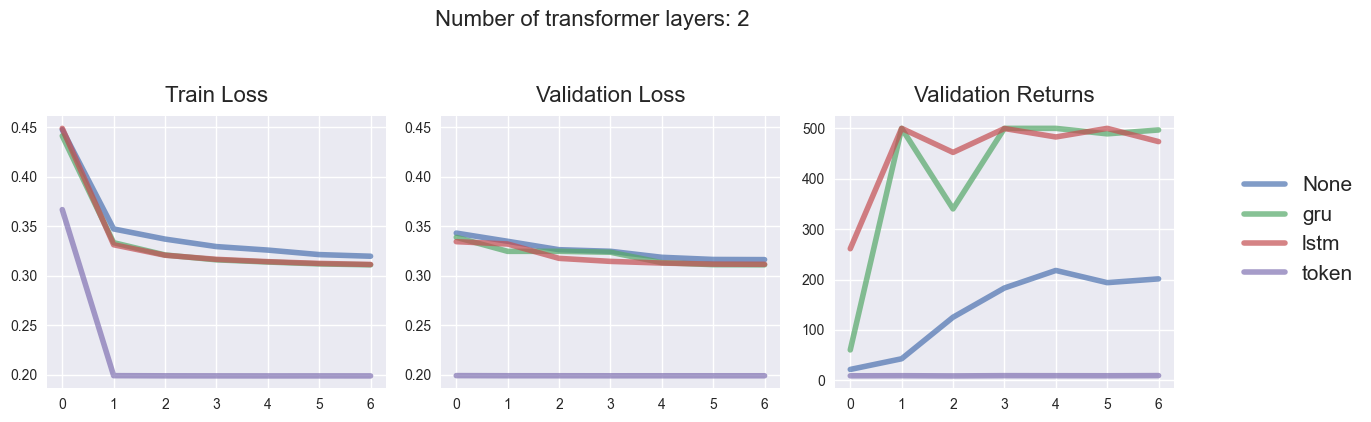

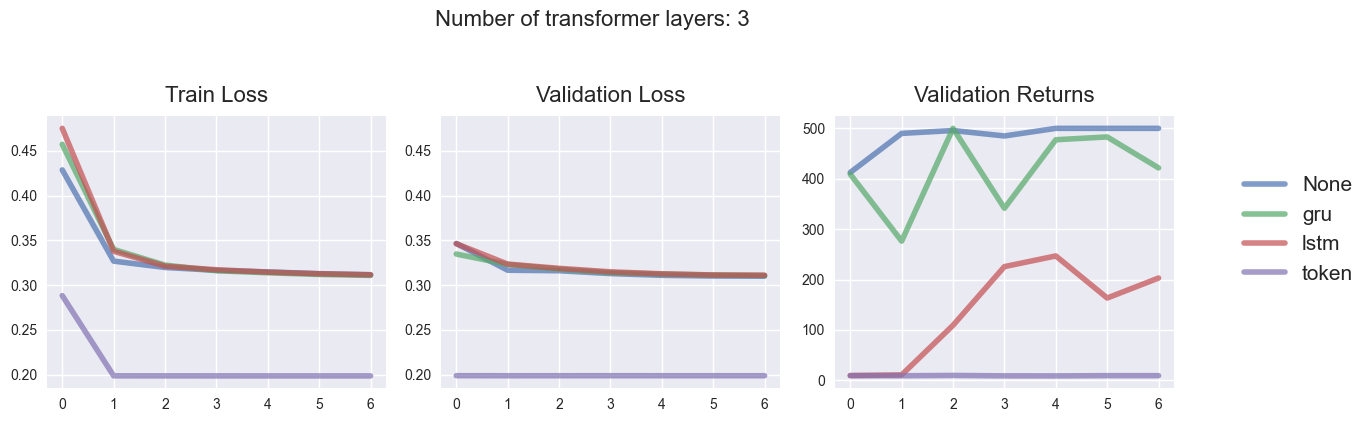

In [8]:
plt.style.use("seaborn-v0_8")

# Set default font sizes
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 15

for n_layer in sorted(data.keys()):
    fig = plt.figure(figsize=(12, 4))
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2])
    axs = [ax1, ax2, ax3]
    
    fig.suptitle(f"Number of transformer layers: {n_layer}", fontsize=16, y=1.05)

    axs[0].set_title("Train Loss", pad=10)
    axs[1].set_title("Validation Loss", pad=10)
    axs[2].set_title("Validation Returns", pad=10)

    handles, labels = [], []

    for memory_type in ["None", "gru", "lstm", "token"]:
        df = data[n_layer][memory_type]

        line1, = axs[0].plot(df["train_loss"], label=memory_type, lw=4, alpha=0.7)
        line2, = axs[1].plot(df["val_loss"], label=memory_type, lw=4, alpha=0.7)
        line3, = axs[2].plot(df["val_returns"], label=memory_type, lw=4, alpha=0.7)
        
        handles.append(line1)
        labels.append(memory_type)

    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))
    
    plt.tight_layout()

1. **Training efficiency**

    *Loss*
    - Token memory models converge fastest on Train/Val loss within 2 epochs
    - GRU and LSTM also converge quickly on loss within 3 epochs
    - Transformer without memory converges slowest on loss

    *Returns*
    - GRU and LSTM (with 1-2 transformer layers) achieve high validation returns rapidly within 2 epochs
    - Without memory and Token memory show little to no improvement in returns throughout training

2. **Final performance metrics**
    - GRU (1-3 layers) and LSTM (1-2 layers) achieve near-optimal returns in simulation (optimal like a PPO expert policy)
    - Transformer wihtout memory and with Token memory type achieve low returns...
    - btw Token memory model achieves the best losses on the dataset, but fails in a simulation. It means that in an offline setting learning the dataset doesn't mean perform well as the model doesn't learn any generalization abilities (it is very similar to overfitting, but here validation loss does not increase)

3. **Data requirements for convergence**
    - The dataset is an expert dataset as it contains almost perfect results. May be (i am not sure) this kind of dataset is too complicated for some models (i.e. without memory with only 1 layer) to extract information from it (but probably it is just a limitation of the architecture, but i haven't carrying out experiments with another datasets, only the expert one, so it is not proven ;))))))

4. **Overall impact of adding memory modules**
    - Suggesting that DT without memory limited by its architecture to learn POMDP, we can conclude that long-term memory can be crucial for solving POMDP (like non-explicitly reconstructing POMDP to MDP)

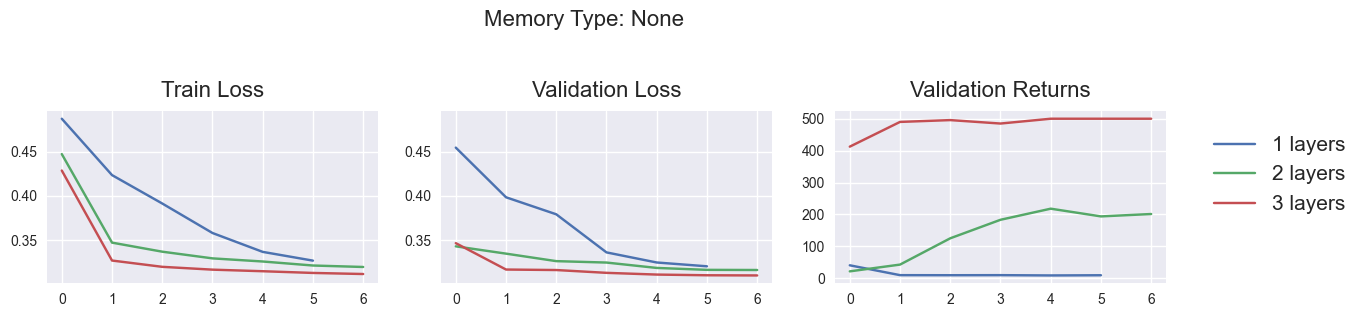

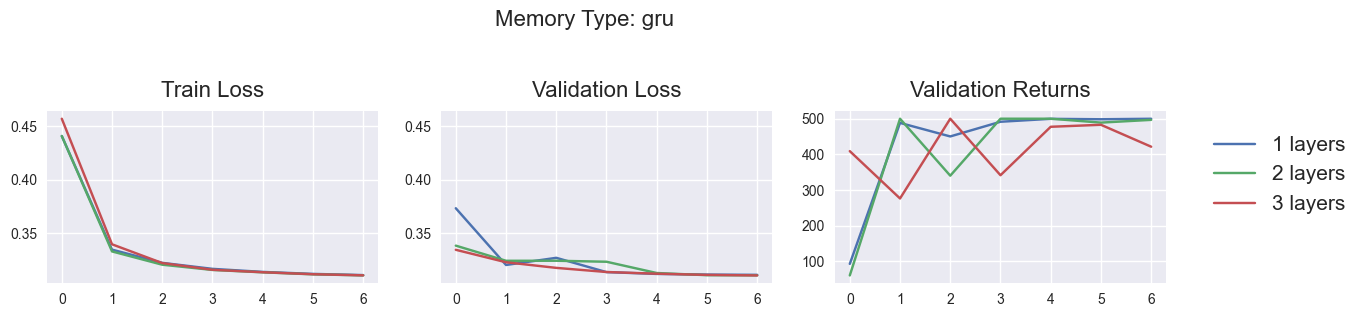

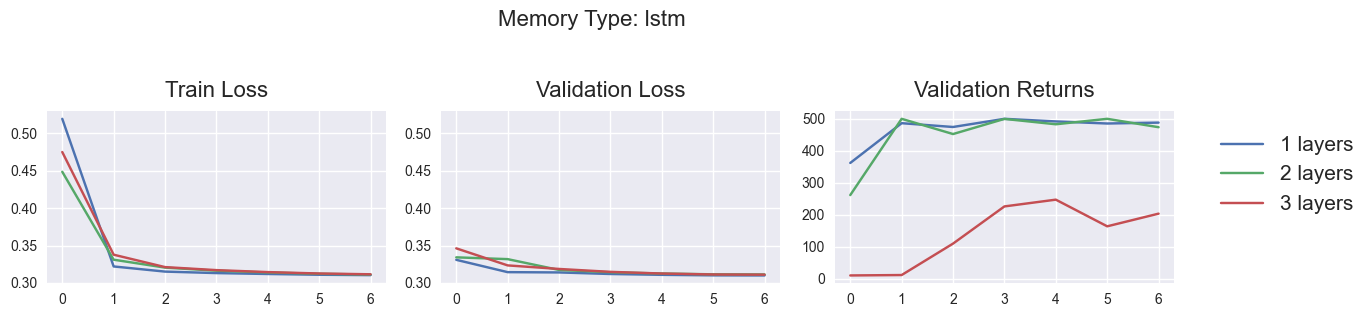

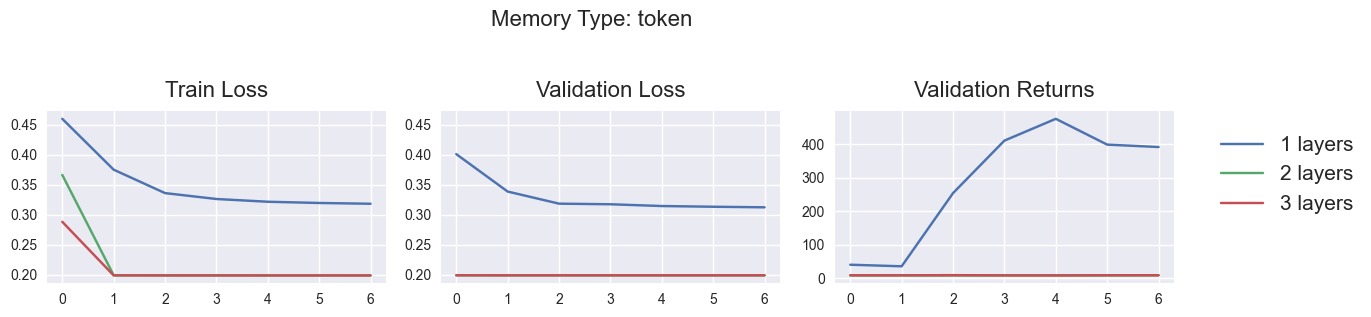

In [4]:
plt.style.use("seaborn-v0_8")

# Set default font sizes
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 15

for memory_type in ["None", "gru", "lstm", "token"]:
    fig = plt.figure(figsize=(12, 3))
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2])
    axs = [ax1, ax2, ax3]
    
    fig.suptitle(f"Memory Type: {memory_type}", fontsize=16, y=1.05)

    axs[0].set_title("Train Loss", pad=10)
    axs[1].set_title("Validation Loss", pad=10)
    axs[2].set_title("Validation Returns", pad=10)

    handles, labels = [], []

    for n_layer in sorted(data.keys()):
        df = data[n_layer][memory_type]

        line1, = axs[0].plot(df["train_loss"], label=f"{n_layer} layers")
        line2, = axs[1].plot(df["val_loss"], label=f"{n_layer} layers")
        line3, = axs[2].plot(df["val_returns"], label=f"{n_layer} layers")
        
        handles.append(line1)
        labels.append(f"{n_layer} layers")

    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))
    
    plt.tight_layout()

For additional analysis (and as seen on the previous charts) i've trained models with each memory types with different number of transformer layers especially to analyze how well it scales 

1. **None**
    Improves from more transformer layers. Each additional layer improved its ability to learn from the data (lower losses) and achieve significantly higher returns, with 3 layers achieving near-optimal results

2. **GRU**
    Perform good even with just 1 transformer layer. Adding more transformer layers (2 or 3) maintained this high level of performance, showing that GRU scales well and it is more stable in terms of model size

3. **LSTM**
    Performed very well with 1 and 2 transformer layers achieving top results. But the performance dropped with 3 transformer layers, suggesting it doesn't scale as well to larger transformer sizes in this setup and can be less stable

4. **Token**
    Did not scale well. While more transformer layers helped it fit the data perfectly (very low losses), its performance in the simulation remained poor indicating overfitting on the dataset

And at the and i would also like to say that i've trained each model several times and from time to time each of them can perform bad or good, but gru showed itself as the most stable in terms of seed, whereas others like vanilla DT and token memory showed good results very rare (there was only 1/~10 run when None perform 50/50 with 1 layer and 1/~10 when token memories showed excellent results with 2 layers), but unfortunately i didn't implement logging with different seeds...